In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders
from model import get_pretrained_emb, EncoderRNN, DecoderRNN, DecoderAttnRNN, EncoderDecoder, EncoderDecoderAttn
from train_eval import train_and_eval, count_parameters, summarize_results, load_experiment_log, \
    plot_single_learning_curve, plot_multiple_learning_curves
import pickle as pkl 
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# params required for generating data loaders 

SRC_LANG = 'vi'
TARG_LANG = 'en'

SRC_MAX_SENTENCE_LEN = 10
TARG_MAX_SENTENCE_LEN = 10
SRC_VOCAB_SIZE = 30000 
TARG_VOCAB_SIZE = 30000 

BATCH_SIZE = 64 

In [3]:
# takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [4]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, filter_long=False)
data_minibatch = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=BATCH_SIZE, filter_long=False) 
data_minitrain = process_data(SRC_LANG, TARG_LANG, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, vocab, sample_limit=1000, filter_long=False)

In [5]:
# create dataloaders 
loaders_full = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minibatch = create_dataloaders(data_minibatch, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
loaders_minitrain = create_dataloaders(data_minitrain, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [6]:
# model architecture params 
NETWORK_TYPE = 'rnn'
RNN_CELL_TYPE = 'gru'
NUM_LAYERS = 2 
ENC_HIDDEN_DIM = 512
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 1
ENC_DROPOUT = 0
DEC_DROPOUT = 0
ATTENTION_TYPE = 'additive'

# training params  
NUM_EPOCHS = 5
LR = 0.0003 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = False

# name the model and experiment 
EXPERIMENT_NAME = 'hyperparameter_tuning_num_layers'
if NETWORK_TYPE == 'rnn': 
    MODEL_NAME = '{}-rnn-{}-attn'.format(SRC_LANG, ATTENTION_TYPE)
elif NETWORK_TYPE == 'cnn': 
    MODEL_NAME = '{}-cnn'.format(SRC_LANG)

In [7]:
# store as dict to save to results later 
params = {'experiment_name': EXPERIMENT_NAME,'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'rnn_cell_type': RNN_CELL_TYPE, 'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 
          'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 'src_vocab_size': SRC_VOCAB_SIZE, 
          'targ_vocab_size': TARG_VOCAB_SIZE, 'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 
          'dec_hidden_dim': DEC_HIDDEN_DIM, 'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 
          'clip_grad_max_norm': CLIP_GRAD_MAX_NORM, 'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'attention_type': ATTENTION_TYPE, 'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 
          'learning_rate': LR, 'optimizer': OPTIMIZER, 'lazy_train': LAZY_TRAIN} 

In [9]:
for candidate in [1024, 512, 256, 128]: 
    
    print("Training with enc_dim = {} and dec_dim = {}".format(candidate, 2*candidate))
    
    # overwrite relevant key-value in params 
    params['enc_dropout'] = candidate 
    params['dec_dropout'] = 2 * candidate 
    params['model_name'] = '{}-rnn-{}-attn-{}-hidden-dim'.format(SRC_LANG, ATTENTION_TYPE, candidate)
    
    # instantiate model 
    encoder = EncoderRNN(rnn_cell_type=RNN_CELL_TYPE, enc_hidden_dim=candidate, num_layers=NUM_LAYERS, 
                         src_max_sentence_len=SRC_MAX_SENTENCE_LEN, enc_dropout=ENC_DROPOUT, 
                         pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
    decoder = DecoderAttnRNN(rnn_cell_type=RNN_CELL_TYPE, dec_hidden_dim=2*candidate, enc_hidden_dim=candidate, 
                             num_layers=NUM_LAYERS, targ_vocab_size=TARG_VOCAB_SIZE, 
                             src_max_sentence_len=SRC_MAX_SENTENCE_LEN, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                             dec_dropout=DEC_DROPOUT, attention_type=ATTENTION_TYPE,
                             pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], 
                                                                    vocab[TARG_LANG]['token2id']))
    model = EncoderDecoderAttn(encoder, decoder, vocab[TARG_LANG]['token2id']).to(device) 
    
    # train and eval 
    model, results = train_and_eval(
        model=model, loaders_full=loaders_full, loaders_minibatch=loaders_minibatch, loaders_minitrain=loaders_minitrain, 
        params=params, vocab=vocab, print_intermediate=500, save_checkpoint=True, save_to_log=True, 
        lazy_eval=True, print_attn=False, inspect_samples=3)

Training with enc_dim = 1024 and dec_dim = 2048
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.18, Train BLEU: 0.00, Val BLEU: 0.06, Minutes Elapsed: 0.13
Sampling from val predictions...
Source: hai đứa con_trai nhỏ , giờ không còn nhỏ nữa
Reference: her two little boys , not so little anymore
Model: <SOS> and and the the the the the the the

Source: chúng dọn_sạch những xác_chết đến tận xương . <EOS> <PAD>
Reference: they clean up carcasses right to the bone .
Model: <SOS> and and the the the the the the the

Source: chúng_tôi đã gặp_may với việc lau ảnh bằng tay .
Reference: now , we were lucky with our <UNK> .
Model: <SOS> and and the the the the the the the



Epoch: 0.24, Train Loss: 0.00, Val Loss: 5.82, Train BLEU: 0.00, Val BLEU: 1.99, Minutes Elapsed: 10.57
Sampling from val predictions...
Source: chắc_chắn có_thể nói " <UNK> and <UNK> " nhưng sao_không
Reference: sure , you can say &quot; spatial and temporal
Model: <SOS> &quot; said &quot; &quot; &quot; &quot; &quot; &quot; &quot;

Source: khi người cảnh_sát trung_quốc đến gần họ , tôi đã
Reference: as the chinese officer approached my family , i
Model: <SOS> and the , , , , , , ,

Source: nhưng từ khi xuất_bản " <UNK> love " tôi đã
Reference: but since publishing &quot; crazy love , &quot; i
Model: <SOS> but &quot; &quot; &quot; &quot; &quot; &quot; &quot; &quot;



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.20, Train BLEU: 0.00, Val BLEU: 5.63, Minutes Elapsed: 20.98
Sampling from val predictions...
Source: và mẹo ở đây là sử_dụng những câu đơn và
Reference: and the trick here is to use a single
Model: <SOS> and the is is the the , and and

Source: tôi thấy cảnh giống_như 1 gia_đình đang đánh_cá trên thuyền
Reference: i saw what seemed to be a family fishing
Model: <SOS> i i to the the a the the of

Source: chúng_tôi gặp_gỡ tại quán cà_phê . quán_rượu . <EOS> <PAD>
Reference: we meet at the cafe . we meet at
Model: <SOS> we have have . . . . . <EOS>



Epoch: 0.72, Train Loss: 0.00, Val Loss: 4.84, Train BLEU: 0.00, Val BLEU: 8.61, Minutes Elapsed: 31.38
Sampling from val predictions...
Source: chúng_tôi đã không ưu_tiên quyền công_dân . <EOS> <PAD> <PAD>
Reference: we did not prioritize right . <EOS> <PAD> <PAD>
Model: <SOS> we have not have the . <EOS> <EOS> <EOS>

Source: nó xảy_ra mọi nơi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: it &apos;s everywhere . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s it . <EOS> <EOS> <EOS> . .

Source: tôi chuyển đến thành_phố new_york khi làm công_việc đầu_tiên viết
Reference: i had moved to new york city for my
Model: <SOS> i i to the the the the the the



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.63, Train BLEU: 0.00, Val BLEU: 9.80, Minutes Elapsed: 41.79
Sampling from val predictions...
Source: tôi đã có cơ_hội đi đến đây bằng máy_bay lần
Reference: i got a chance to come by plane for
Model: <SOS> i &apos;ve a opportunity that that that that that

Source: và tôi giúp những người đánh_cá này biết cách làm_việc
Reference: and i helped these five fishermen to work together
Model: <SOS> and i asked the people people who what what

Source: khi nhận lại các bức ảnh từ chúng_tôi , cô
Reference: when she collected the photos from us , she
Model: <SOS> when when &apos;re the the , the , the



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.62, Train BLEU: 0.00, Val BLEU: 8.93, Minutes Elapsed: 43.61
Sampling from val predictions...
Source: hiện_tại , tôi sống ở new orleans , và tôi
Reference: now , i live in new orleans , and
Model: <SOS> i , i i in in , , and

Source: không lâu sau đó , khi tôi đi qua một
Reference: soon after , when i was walking past a
Model: <SOS> not , when , i i back to a

Source: bạn thậm_chí có thể biết được tôi tới <UNK> bằng
Reference: and you can even see how i go from
Model: <SOS> you can you &apos;t know a i i to



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.49, Train BLEU: 0.00, Val BLEU: 10.72, Minutes Elapsed: 53.97
Sampling from val predictions...
Source: " khi làm_việc , tôi không_thể không nghĩ đến mỗi
Reference: &quot; as i worked , i couldn &apos;t help
Model: <SOS> &quot; i i i &apos;t not i &apos;t &apos;t

Source: chúng_tôi đã làm thế tại 300 cộng_đồng trên khắp thế_giới
Reference: we &apos;ve done it in 300 communities around the
Model: <SOS> we &apos;ve been working 300 300 of of the

Source: điều mà bạn nên làm là đấu_tranh cho sự tự_chủ
Reference: but you have to fight for your <UNK> today
Model: <SOS> what what you is is is the is ,



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.38, Train BLEU: 0.00, Val BLEU: 11.10, Minutes Elapsed: 64.33
Sampling from val predictions...
Source: những doanh_nhân chẳng bao_giờ đến dự , và họ chẳng
Reference: entrepreneurs never come , and they never tell you
Model: <SOS> these are are , , they are to ,

Source: múa ba_lê đòi_hỏi một trình_độ chuyên_môn đặc_biệt và trình_độ kỹ_thuật
Reference: now , ballet requires an extraordinary level of expertise
Model: <SOS> because , a a a a and and and

Source: à , để đúc_kết lại , tôi có_thể nói rằng
Reference: well , to conclude , i can say that
Model: <SOS> well , , can , i can say that



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.28, Train BLEU: 0.00, Val BLEU: 11.91, Minutes Elapsed: 74.76
Sampling from val predictions...
Source: và tôi đã nghĩ về cái chết rất nhiều ,
Reference: and i thought about death a lot , and
Model: <SOS> and i thought thinking a lot a , ,

Source: tôi nhận ra rằng vấn_đề chính là giải_pháp . <EOS>
Reference: so i figured that the problem is the solution
Model: <SOS> i realized realized that the is is the .

Source: <UNK> đã tấn_công vào tôi năm ngày_trước đám_cưới của chúng_tôi
Reference: <UNK> first physically attacked me five days before our
Model: <SOS> <UNK> was been in in the in of we



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.38, Minutes Elapsed: 85.22
Sampling from val predictions...
Source: tôi đứng trên sân_khấu này bởi_vì tôi xinh_đẹp , một
Reference: i am on this stage because i am a
Model: <SOS> i i this on because because i i ,

Source: cùng_nhau chúng_ta có_thể làm_cho giường ngủ của chúng_ta bàn_ăn và
Reference: together we can make our beds , our dinner
Model: <SOS> we we us our our our of our the

Source: nhưng những cuộc trao_đổi hiệu_quả không_thể diễn ra nếu các
Reference: but these great conversations can &apos;t occur if our
Model: <SOS> but the the the &apos;t &apos;t if if if



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.26, Train BLEU: 0.00, Val BLEU: 11.57, Minutes Elapsed: 87.06
Sampling from val predictions...
Source: khoảng thời_gian mà chúng_tôi tập_trung dành cho nhau này là
Reference: this very focused time we get to spend together
Model: <SOS> the the time time we we working this this

Source: và người dân đáp rằng , " vâng , đó
Reference: and the <UNK> said , &quot; yes , that
Model: <SOS> and people said said , &quot; well , it

Source: tôi tin rằng chìa_khoá mở cánh_cửa đến thế_giới đó chính
Reference: and i believe the key to opening that door
Model: <SOS> i believe believe that the of the the of



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.25, Train BLEU: 0.00, Val BLEU: 12.31, Minutes Elapsed: 97.48
Sampling from val predictions...
Source: và tiếng_ồn cũng biến mất qua lỗ thấm . <EOS>
Reference: also the noise will disappear in these pores .
Model: <SOS> and the the is the the the . .

Source: tôi có rất nhiều đôi giầy cao gót <UNK> mà
Reference: i do have too many <UNK> heels which i
Model: <SOS> i have a lot lot <UNK> in and and

Source: tom <UNK> : vậy max , bằng cách lấy tất_cả
Reference: so max , by taking all these samples of
Model: <SOS> tom tom : tom tom , the the the



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.21, Train BLEU: 0.00, Val BLEU: 12.20, Minutes Elapsed: 107.90
Sampling from val predictions...
Source: nhiều em chết_đuối . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: many of them drown . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank you . . <EOS> . <EOS> <EOS> <EOS>

Source: câu_hỏi đầu_tiên là : gì cơ ? <EOS> <PAD> <PAD>
Reference: first question to answer for us : so what
Model: <SOS> the first question : : what ? <EOS> ?

Source: việc người bắc triều_tiên phải che dấu danh_tính của mình
Reference: it &apos;s tragic that north koreans have to hide
Model: <SOS> people first the to to to to to their



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.18, Train BLEU: 0.00, Val BLEU: 12.86, Minutes Elapsed: 118.32
Sampling from val predictions...
Source: chúng_tôi <UNK> , nhưng ai cũng vui . <EOS> <PAD>
Reference: we got dirty , and we loved it .
Model: <SOS> we poked , , , , . . <EOS>

Source: tôi chỉ là một người phụ_nữ muốn chia_sẻ câu_chuyện của
Reference: i &apos;m just one woman with a story to
Model: <SOS> i &apos;m a a a who a sharing of

Source: trên hết , <UNK> bị bệnh lao , nhưng vẫn
Reference: on top of that , <UNK> has tuberculosis ,
Model: <SOS> on the , , , the are are ,



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.19, Train BLEU: 0.00, Val BLEU: 13.00, Minutes Elapsed: 128.79
Sampling from val predictions...
Source: tôi không phải công_dân nước đó . <EOS> <PAD> <PAD>
Reference: i wasn &apos;t a citizen of that country .
Model: <SOS> i i not have to . . . <EOS>

Source: anh ta đã thật_sự rất căng_thẳng vì đám_cưới và việc
Reference: he had just been really stressed out by the
Model: <SOS> he was really amazing , , , and and

Source: bức này được chụp vài tuần sau sự_kiện 11/9 ,
Reference: this one was taken just weeks after 9 /
Model: <SOS> this this was taken taken after weeks after 9



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.22, Train BLEU: 0.00, Val BLEU: 12.43, Minutes Elapsed: 130.62
Sampling from val predictions...
Source: trong kỉ_nguyên gia_tăng sự phân_tán của chúng_ta , điều này
Reference: in our age of increasing distractions , it &apos;s
Model: <SOS> in our business , our , , this is

Source: vì_thế chúng_tôi có_thể nhận sự trợ_giúp từ cộng_đồng quốc_tế cho
Reference: so we can benefit from the international community for
Model: <SOS> so we can start the the combination of of

Source: tôi được leo ra khỏi cái hố đó , và
Reference: i got to climb out of that hole ,
Model: <SOS> i was out out out out the of ,



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.78, Minutes Elapsed: 141.06
Sampling from val predictions...
Source: tôi đã nghĩ chỉ có mỗi người ý là khờ_khạo
Reference: i thought it was only us italians <UNK> around
Model: <SOS> i thought it was only to person this <EOS>

Source: với_lại tôi cũng cảm_thấy mệt_mỏi với việc phải lái_xe 45
Reference: plus i got tired of driving 45 minutes round
Model: <SOS> i i i to with a bit 45 45

Source: gần đây , trong một chuyến đi , chúng_tôi đang
Reference: recently , on one trip , we were walking
Model: <SOS> so , , in , , we &apos;re doing



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.22, Train BLEU: 0.00, Val BLEU: 13.18, Minutes Elapsed: 151.50
Sampling from val predictions...
Source: cùng nhau , chúng_ta đã chỉ ra những không_gian công_cộng
Reference: together , we &apos;ve shown how powerful our public
Model: <SOS> together , we &apos;ve out a spaces . .

Source: một ngày , cơn ác_mộng đó đã thành sự_thật ,
Reference: one day , my worst nightmare came true ,
Model: <SOS> one day , the light , , , ,

Source: với một chiếc điện_thoại_di_động , bạn cũng có_thể đăng_tải một
Reference: with a mobile phone , you can tweet a
Model: <SOS> with a cnc , , you can imagine a



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.23, Train BLEU: 0.00, Val BLEU: 13.70, Minutes Elapsed: 161.94
Sampling from val predictions...
Source: cộng_đồng của tôi , người maasai , tin rằng chúng_tôi
Reference: my community , the maasai , we believe that
Model: <SOS> my community , the the , that we we

Source: chúng là cách để chúng_tôi dừng thời_gian trong một tuần
Reference: they &apos;re also ways for us to freeze time
Model: <SOS> they &apos;re a to to us in a a

Source: cô ấy đã tự lau sạch chúng và dừng lại
Reference: she had started <UNK> them herself and stopped when
Model: <SOS> she &apos;s the the and and and and and



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.26, Train BLEU: 0.00, Val BLEU: 12.91, Minutes Elapsed: 172.34
Sampling from val predictions...
Source: bất_cứ ai khoẻ_mạnh hoặc mắc bệnh parkinson có_thể gọi tới
Reference: anyone healthy or with parkinson &apos;s can call in
Model: <SOS> anybody who all who to to or to get

Source: thành_phố có một_số công_trình kiến_trúc đẹp nhất trên thế_giới ,
Reference: the city has some of the most beautiful architecture
Model: <SOS> there there has some some some in in in

Source: do_vậy , điều đầu_tiên tôi muốn nói với bạn là
Reference: so my first message for you is that domestic
Model: <SOS> so the first thing to want to to to



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.30, Train BLEU: 0.00, Val BLEU: 12.37, Minutes Elapsed: 174.16
Sampling from val predictions...
Source: và tôi cảm_thấy có một áp_lực không thoải_mái trong phòng
Reference: and i feel like there &apos;s an uncomfortable tension
Model: <SOS> and i felt a a &apos;s a part of

Source: giống_như ba_lê nó cần được đào_tạo đặc_biệt . <EOS> <PAD>
Reference: and like ballet , it takes an extraordinary level
Model: <SOS> it &apos;s , it it &apos;s to be .

Source: tương_đương với 20 lần công_viên trung_tâm , <EOS> <PAD> <PAD>
Reference: that &apos;s 20 central parks . <EOS> <PAD> <PAD>
Model: <SOS> that &apos;s for 20 for 20 the &apos;s the



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.32, Train BLEU: 0.00, Val BLEU: 12.97, Minutes Elapsed: 184.51
Sampling from val predictions...
Source: " trước_khi tôi chết , tôi muốn được ôm cô
Reference: &quot; before i die , i want to hold
Model: <SOS> &quot; i i &apos;m , i wanted to be

Source: tôi đã có cơ_hội đi đến đây bằng máy_bay lần
Reference: i got a chance to come by plane for
Model: <SOS> i had had chance to go it the to

Source: tuy_nhiên , từng chút từng chút một , sự hưng_phấn
Reference: however , bit by bit , the euphoria of
Model: <SOS> but , the the a , a a of



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.33, Train BLEU: 0.00, Val BLEU: 13.02, Minutes Elapsed: 194.84
Sampling from val predictions...
Source: cùng một nhóm phụ_nữ tuyệt_vời , tôi đồng sáng_lập <UNK>
Reference: with an amazing group of women , i <UNK>
Model: <SOS> but a wonderful , , i , i decided

Source: tôi muốn họ lấy chúng , nhưng cùng lúc đó
Reference: i want them to take it , but at
Model: <SOS> i want them them them them , but i

Source: không_ai khởi_đầu một công_ty một_mình . không_ai cả . <EOS>
Reference: nobody started a company alone . no one .
Model: <SOS> nobody one a a company company . . .



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.40, Train BLEU: 0.00, Val BLEU: 13.84, Minutes Elapsed: 205.21
Sampling from val predictions...
Source: có_thể sự thiếu_sót không chỉ là về mặt bình_quyền của
Reference: maybe what was missing was not the women only
Model: <SOS> maybe design &apos;s not not the the the of

Source: không bị hư_hỏng trầm_trọng , nhưng chỗ bị thấm nước
Reference: not terribly damaged , but where the water had
Model: <SOS> it is empty , but it are are ,

Source: tôi lúc_nào cũng tự_hỏi là tại_sao họ lại có điện
Reference: i always wondered why they had lights but we
Model: <SOS> i &apos;m wondered why how they they even <EOS>



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.41, Train BLEU: 0.00, Val BLEU: 13.15, Minutes Elapsed: 215.53
Sampling from val predictions...
Source: nhưng chủ_yếu là thật khó mà tháo tung một di_sản
Reference: but mostly it was difficult to unpack a legacy
Model: <SOS> but it &apos;s it , the , the ,

Source: anh ấy phải đi về hướng dòng nước khi còi
Reference: he had to go towards the water as the
Model: <SOS> he had to walk about the water and the

Source: tôi mong rằng bạn nhìn ra được - - những
Reference: and i hope what you &apos;re seeing is that
Model: <SOS> i i i you you see at at at



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.48, Train BLEU: 0.00, Val BLEU: 12.06, Minutes Elapsed: 217.33
Sampling from val predictions...
Source: thậm_chí anh ta chĩa súng vào đầu tôi , đẩy
Reference: even though he held those loaded guns to my
Model: <SOS> even he he he that on on my my

Source: do_vậy đối_với <UNK> online và open data city , tôi
Reference: so together with <UNK> online and open data city
Model: <SOS> so the the the and the the the ,

Source: và tôi có được một công_tắc để có_thể tắt và
Reference: and i got a switch where i can switch
Model: <SOS> and i have a one to to get for

Model training completed in 217 minutes with 4.18 best validation loss and 13.84 best validation BLEU.
Training with enc_dim = 512 and dec_dim = 1024
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.25, Train BLEU: 0.00, Val BLEU: 0.06, Minutes Elapsed: 0.09
Sampling from val predictions...
Source: sau đó tôi có băn_khoăn một_chút , nên làm_gì với
Reference: so i was a little bit skeptical , what


Epoch: 0.24, Train Loss: 0.00, Val Loss: 5.96, Train BLEU: 0.00, Val BLEU: 2.15, Minutes Elapsed: 8.28
Sampling from val predictions...
Source: tôi không biết điều gì xảy ra trong lúc đó
Reference: that was , i don &apos;t know what happened
Model: <SOS> i i i to to to to to to

Source: nhưng từ khi xuất_bản " <UNK> love " tôi đã
Reference: but since publishing &quot; crazy love , &quot; i
Model: <SOS> but , , , , , , , ,

Source: đôi_khi chúng tạo nên các ổ gà . <EOS> <PAD>
Reference: sometimes you can create potholes with that . <EOS>
Model: <SOS> so &apos;s the the . . . . .



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.35, Train BLEU: 0.00, Val BLEU: 4.94, Minutes Elapsed: 16.49
Sampling from val predictions...
Source: và tôi nhận ra : một trong những thứ quan_trọng
Reference: and it hit me : one of the most
Model: <SOS> and i i , : a is is of

Source: do_vậy đối_với <UNK> online và open data city , tôi
Reference: so together with <UNK> online and open data city
Model: <SOS> so you can , , , , , ,

Source: cho đến nay , tôi đã giúp lắp_đặt cho 7
Reference: since now , i &apos;ve set up seven homes
Model: <SOS> now , , i i to to the the



Epoch: 0.72, Train Loss: 0.00, Val Loss: 4.97, Train BLEU: 0.00, Val BLEU: 7.76, Minutes Elapsed: 24.75
Sampling from val predictions...
Source: có một vài lần , ngôi trường đột_nhiên đóng_cửa khoảng
Reference: from time to time , the school would suddenly
Model: <SOS> there &apos;s , , , the the of the

Source: bởi sự_thật tôi là một nạn_nhân điển_hình của bạo_lực gia_đình
Reference: because it turns out that i &apos;m actually a
Model: <SOS> so i i i a a a a a

Source: afghanistan nhìn rất khác khi nhìn từ mỹ . <EOS>
Reference: afghanistan looks so different from here in america .
Model: <SOS> they are are the the . . <EOS> .



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.74, Train BLEU: 0.00, Val BLEU: 8.56, Minutes Elapsed: 33.02
Sampling from val predictions...
Source: cái trường ấy trong một căn nhà , hơn 100
Reference: the school was in a house , more than
Model: <SOS> she &apos;s is in a , , , the

Source: tôi tin_tưởng rằng các bạn sẽ nhìn_thấy ngày_càng nhiều người
Reference: i &apos;m confident that you will see more and
Model: <SOS> i i that to you you going you you

Source: bước tiếp_theo trong kịch_bản bạo_lực này là đưa_vào sự đe_doạ
Reference: the next step in the domestic violence pattern is
Model: <SOS> now was of in this of of is the



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.74, Train BLEU: 0.00, Val BLEU: 8.76, Minutes Elapsed: 34.45
Sampling from val predictions...
Source: và người dân đáp rằng , " vâng , đó
Reference: and the <UNK> said , &quot; yes , that
Model: <SOS> and people people , , &quot; , , it

Source: <UNK> sống và ngự_trị trong thế_giới của riêng mình ,
Reference: <UNK> lived and reigned in his own world ,
Model: <SOS> <UNK> and and and and the of of ,

Source: hai từ có nguồn gốc_từ tiếng la_tinh " <UNK> ,
Reference: the two words come from the latin root &quot;
Model: <SOS> the have of , have the <UNK> of ,



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.57, Train BLEU: 0.00, Val BLEU: 10.77, Minutes Elapsed: 42.64
Sampling from val predictions...
Source: nhưng nếu_như nếu bệnh_nhân có_thể làm xét_nghiệm này ở nhà
Reference: but what if patients could do this test at
Model: <SOS> but if if can do this this this in

Source: chúng_ta đang ở giai_đoạn cuối_cùng của cuộc cách_mạng công_nghiệp đầu_tiên
Reference: we are at the end of the first industrial
Model: <SOS> we &apos;re in the of of the of of

Source: và tôi đã nhìn thấy xác họ nổi trên sông
Reference: sometimes , i saw dead bodies floating down the
Model: <SOS> and i thought see see that they they the



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.44, Train BLEU: 0.00, Val BLEU: 11.17, Minutes Elapsed: 50.88
Sampling from val predictions...
Source: không tốn thời_giờ vàng_bạc của nhân_viên . <EOS> <PAD> <PAD>
Reference: no expensive staff time required . <EOS> <PAD> <PAD>
Model: <SOS> not &apos;s not the <EOS> <EOS> . . .

Source: gần_đây hơn , nếu bạn đang theo_dõi tin_tức ở kenya
Reference: more recently , if you &apos;ve been following the
Model: <SOS> now , , if you &apos;re in at in

Source: peter <UNK> là một giáo_sư triết_học trước khi làm công_việc
Reference: peter <UNK> was a professor of philosophy before becoming
Model: <SOS> robert <UNK> was a <UNK> of when that when



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.33, Train BLEU: 0.00, Val BLEU: 11.87, Minutes Elapsed: 59.14
Sampling from val predictions...
Source: nhưng tôi đấu_tranh để duy_trì góc nhìn này trong cuộc_sống
Reference: but i struggle to maintain this perspective in my
Model: <SOS> but i decided to to this in in in

Source: và tôi có được một công_tắc để có_thể tắt và
Reference: and i got a switch where i can switch
Model: <SOS> and i have a a that to to to

Source: tôi sẽ nói cho bạn biết tại_sao . <EOS> <PAD>
Reference: and i &apos;ll tell you why . <EOS> <PAD>
Model: <SOS> i &apos;m &apos;m tell you why . <EOS> .



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.26, Train BLEU: 0.00, Val BLEU: 12.69, Minutes Elapsed: 67.43
Sampling from val predictions...
Source: và tôi đã quyết_định sẽ gửi đơn_kiện tới toà_án ,
Reference: so i decided to start a lawsuit against them
Model: <SOS> and i decided to to the the of ,

Source: tôi gặp những bé trai này lúc 5 giờ sáng
Reference: i met these boys at five in the morning
Model: <SOS> i i the i i i , , ,

Source: viết lại cuộc_đời họ như nhưng người hạnh_phúc , đáng_yêu
Reference: <UNK> survivors as wonderful , lovable people with full
Model: <SOS> and they them , , , they , ,



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.29, Train BLEU: 0.00, Val BLEU: 11.87, Minutes Elapsed: 68.87
Sampling from val predictions...
Source: ông ấy la lên : " bọn taliban đã đi
Reference: &quot; the taliban are gone ! &quot; my father
Model: <SOS> he said said , , , &quot; &quot; &quot;

Source: một trong số điều thông_minh nhất <UNK> đã làm ,
Reference: one of the smartest things <UNK> did , from
Model: <SOS> one of the most that the the , ,

Source: không bị hư_hỏng trầm_trọng , nhưng chỗ bị thấm nước
Reference: not terribly damaged , but where the water had
Model: <SOS> not &apos;s , , , , &apos;s &apos;s of



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.22, Train BLEU: 0.00, Val BLEU: 12.98, Minutes Elapsed: 77.12
Sampling from val predictions...
Source: và trong bức ảnh này , thực_ra tôi chưa hề
Reference: and in this picture , i had actually never
Model: <SOS> and in this picture , i &apos;m never that

Source: tôi khám_phá ra rằng sư_tử sợ ánh_sáng chuyển_động . <EOS>
Reference: and i discovered that lions are afraid of a
Model: <SOS> i &apos;m realized that that was <EOS> . <EOS>

Source: một buổi sáng mà tôi không_thể nào quên được .
Reference: a morning that i will never forget . <EOS>
Model: <SOS> a one that i couldn &apos;t get . <EOS>



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.15, Train BLEU: 0.00, Val BLEU: 13.03, Minutes Elapsed: 85.40
Sampling from val predictions...
Source: nhưng sau đó tôi đã nói , tôi muốn công_khai
Reference: but then i said , i want to go
Model: <SOS> but then i said , i want to to

Source: đây nên đáng là nguyên_tắc đầu_tiên về viện_trợ . <EOS>
Reference: this should be the first principle of aid .
Model: <SOS> this is the the first first of . .

Source: ở new_york , chỉ có <UNK> ngàn người da_đen và
Reference: and there are only <UNK> young black and latino
Model: <SOS> in the , , , , <UNK> and and



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.11, Train BLEU: 0.00, Val BLEU: 13.07, Minutes Elapsed: 93.74
Sampling from val predictions...
Source: bạn không_thể nào bị sỉ_nhục tồi_tệ hơn thế , và
Reference: you could not get a worse insult , and
Model: <SOS> you cannot &apos;t a more more of , and

Source: tôi đang nói về việc giao công_việc cho mọi người
Reference: what i &apos;m talking about is putting people to
Model: <SOS> i &apos;m &apos;m talking about the future for for

Source: thật đáng_tiếc sau khi bạn_học xong , bạn viết <UNK>
Reference: unfortunately after you &apos;ve gone to school , and
Model: <SOS> it &apos;s is , after the the , you



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.08, Train BLEU: 0.00, Val BLEU: 13.90, Minutes Elapsed: 102.10
Sampling from val predictions...
Source: khi trượt tay , tôi <UNK> nhớ lại người thợ_mỏ
Reference: when my hand slips , i suddenly remember a
Model: <SOS> when i was , i i i my ,

Source: tôi nhận ra rằng đó là một khoảng khắc có
Reference: i realized that this was a symbolic moment in
Model: <SOS> i found that was was a part of that

Source: người nào sẽ sáng_chế ra cái công_nghệ cho cuộc cách_mạng
Reference: who is going to invent the technology for the
Model: <SOS> people would give to give the technology of the



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.13, Train BLEU: 0.00, Val BLEU: 13.11, Minutes Elapsed: 103.55
Sampling from val predictions...
Source: vào tháng 11 năm 2011 , đang theo_dõi tình hình
Reference: on march 11 , 2011 , i watched from
Model: <SOS> in january 11th 2011 2011 the the the the

Source: tôi đã không_thể trực_tiếp giúp gì cho họ . <EOS>
Reference: i couldn &apos;t offer them any direct help .
Model: <SOS> i couldn &apos;t have to job them them them

Source: tất_nhiên những người dân bản_địa <UNK> hứng_thú làm công_việc này
Reference: and of course the local people had absolutely no
Model: <SOS> of of people of people of of this this



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 13.83, Minutes Elapsed: 111.83
Sampling from val predictions...
Source: với_lại tôi cũng cảm_thấy mệt_mỏi với việc phải lái_xe 45
Reference: plus i got tired of driving 45 minutes round
Model: <SOS> so i i to with with with i i

Source: nhưng cũng là có chọn_lọc . <EOS> <PAD> <PAD> <PAD>
Reference: he has a selective one , though . <EOS>
Model: <SOS> but it clearly . . <EOS> <EOS> &apos;s it

Source: đây là vùng nam los angeles . <EOS> <PAD> <PAD>
Reference: this is south los angeles . <EOS> <PAD> <PAD>
Model: <SOS> this is the los los los <EOS> <EOS> .



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.05, Train BLEU: 0.00, Val BLEU: 14.08, Minutes Elapsed: 120.15
Sampling from val predictions...
Source: khi chạy_trốn con sóng , để giữ lấy tính_mạng ,
Reference: as they had run from the wave , and
Model: <SOS> when the as , cold , , , to

Source: bạn có_thể thấy tất_cả điều đó . <EOS> <PAD> <PAD>
Reference: you can see all of this . <EOS> <PAD>
Model: <SOS> you can see all . . . <EOS> .

Source: vào ngày 13 tháng 5 , tôi tìm đường đến
Reference: on may the 13th , i made my way
Model: <SOS> on the 13th , , , i a to



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.05, Train BLEU: 0.00, Val BLEU: 13.79, Minutes Elapsed: 128.51
Sampling from val predictions...
Source: thật ra , trong 10 năm . <EOS> <PAD> <PAD>
Reference: actually , for 10 years . <EOS> <PAD> <PAD>
Model: <SOS> in , in 10 years . <EOS> <EOS> .

Source: nhưng sau đó tôi đã nói , tôi muốn công_khai
Reference: but then i said , i want to go
Model: <SOS> but then i said , i wanted to to

Source: sau sáu tháng tại nhật bản , 1.100 tình_nguyện viên
Reference: after six months in japan , 1,100 volunteers had
Model: <SOS> after after months ago , , the country country



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.04, Train BLEU: 0.00, Val BLEU: 14.27, Minutes Elapsed: 136.88
Sampling from val predictions...
Source: bởi_vì hoà_bình như thuật giả kim , nó cần đến
Reference: for peace has an alchemy , and this alchemy
Model: <SOS> because it , like the , , it needs

Source: một trát hầu_toà vì trồng cây trên mảnh đất mà
Reference: a warrant for planting food on a piece of
Model: <SOS> a was is , , in the country ,

Source: cảm_ơn các bạn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you . . . .



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 13.91, Minutes Elapsed: 138.34
Sampling from val predictions...
Source: nhưng tôi đưa kí_ức mình quay trở_lại những điều các
Reference: but i cast my mind back to the things
Model: <SOS> but i &apos;ve him back back how the .

Source: đó là lúc 7 giờ sáng khi tôi còn đang
Reference: it was 7 a.m. i still had on my
Model: <SOS> it &apos;s a of of of when the of

Source: những kỹ_sư tôi làm_việc cùng dạy tôi phải_biết <UNK> hoá
Reference: and because the engineers that i &apos;ve worked with
Model: <SOS> my i i work that work work work working



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.02, Minutes Elapsed: 146.62
Sampling from val predictions...
Source: tôi nghĩ cuộc_đời mình đến đây là chấm_dứt , nhưng
Reference: i thought my life was over , but i
Model: <SOS> i think the life is this , but but

Source: làm ý_tưởng mình dễ_hiểu không phải là hạ_thấp chúng .
Reference: and making your ideas accessible is not the same
Model: <SOS> the the idea idea is not not to .

Source: bà ấy đây . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: there she is . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> she &apos;s here . . . . . .



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.04, Train BLEU: 0.00, Val BLEU: 14.30, Minutes Elapsed: 154.91
Sampling from val predictions...
Source: nhưng rất nhiều người đã chết . <EOS> <PAD> <PAD>
Reference: but many die . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> but many lot people have died &apos;t . .

Source: chúng_ta có 8 loài kền_kền xuất_hiện tại kenya , trong
Reference: we have eight species of vultures that occur in
Model: <SOS> we have eight list of in in in in

Source: thật_sự như bạn thấy ở đây vật_liệu này có dấu_hiệu
Reference: here you see actually how the damage appears in
Model: <SOS> but , you see china , is is a



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.34, Minutes Elapsed: 163.22
Sampling from val predictions...
Source: okay , bạn có_thể bán nó không ? bạn có_thể
Reference: okay , can you sell it ? can you
Model: <SOS> okay , you you take it ? you you

Source: sự ngược_đãi có_thể ảnh_hưởng đến con_gái bạn , em_gái của
Reference: abuse could be affecting your daughter , your sister
Model: <SOS> the can be your children children , your daughter

Source: vậy không_gian bị bỏ_bê này đã trở_thành một không_gian kiến_tạo
Reference: so this neglected space became a constructive one ,
Model: <SOS> so this this is became a a of .



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.08, Train BLEU: 0.00, Val BLEU: 13.91, Minutes Elapsed: 171.54
Sampling from val predictions...
Source: vì_thế tôi đã có một ý_tưởng . <EOS> <PAD> <PAD>
Reference: so i had an idea . <EOS> <PAD> <PAD>
Model: <SOS> so i had a idea . <EOS> &apos;ve a

Source: bấy_giờ , điều cuối_cùng tôi muốn làm là rời_bỏ new_york
Reference: now , the last thing i wanted to do
Model: <SOS> now , the last thing i want to do

Source: hơn 70 phần_trăm tội_ác bạo_hành gia_đình xảy_ra sau khi nạn_nhân
Reference: over 70 percent of domestic violence murders happen after
Model: <SOS> over 70 percent of the families in the the



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 13.39, Minutes Elapsed: 172.99
Sampling from val predictions...
Source: không_khí rất vui_vẻ , và họ chia_sẻ những câu_chuyện về
Reference: it was cool , and they just shared the
Model: <SOS> it &apos;s so big , and share shared stories

Source: hình_ảnh có sức_mạnh rất lớn , nhưng nó cũng rất
Reference: image is powerful , but also image is superficial
Model: <SOS> the &apos;s a very , , it it very

Source: khi 27 tuổi , tôi đã quyết_định chỉ hưởng_ứng với
Reference: i decided when i was 27 years old to
Model: <SOS> when i , years years years years i i

Model training completed in 172 minutes with 4.04 best validation loss and 14.34 best validation BLEU.
Training with enc_dim = 256 and dec_dim = 512
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.27, Train BLEU: 0.00, Val BLEU: 0.03, Minutes Elapsed: 0.08
Sampling from val predictions...
Source: chúng_tôi bắt_đầu hẹn_hò , và anh ta yêu tôi về
Reference: we started 

Epoch: 0.24, Train Loss: 0.00, Val Loss: 6.04, Train BLEU: 0.00, Val BLEU: 1.27, Minutes Elapsed: 8.14
Sampling from val predictions...
Source: tôi không biết điều gì xảy ra trong lúc đó
Reference: that was , i don &apos;t know what happened
Model: <SOS> i i , , , , , , ,

Source: tôi đang nói về việc giao công_việc cho mọi người
Reference: what i &apos;m talking about is putting people to
Model: <SOS> i i , , , , , , ,

Source: trồng một cây sẽ cho bạn 1.000 , 10.000 hạt_giống
Reference: growing one plant will give you 1,000 , 10,000
Model: <SOS> so , , , , , , , ,



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.49, Train BLEU: 0.00, Val BLEU: 3.75, Minutes Elapsed: 16.21
Sampling from val predictions...
Source: uỷ_viên hội_đồng đó thậm_chí còn gọi tới và nói rằng
Reference: my <UNK> even called in and said how they
Model: <SOS> the the the the and and and and and

Source: với một chiếc điện_thoại_di_động , bạn có_thể ghi lại hình_ảnh
Reference: with a mobile phone , you can shoot a
Model: <SOS> this &apos;s of , , you you to to

Source: đó là lúc 7 giờ sáng khi tôi còn đang
Reference: it was 7 a.m. i still had on my
Model: <SOS> this is the of , i to i ,



Epoch: 0.72, Train Loss: 0.00, Val Loss: 5.15, Train BLEU: 0.00, Val BLEU: 5.94, Minutes Elapsed: 24.25
Sampling from val predictions...
Source: em không nhớ liệu em có xoáy thanh kẹo sô
Reference: he doesn &apos;t remember if he stole my chocolate
Model: <SOS> he don &apos;t the to the the the the

Source: nó xảy_ra mọi nơi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: it &apos;s everywhere . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s the . <EOS> <EOS> . . .

Source: tôi giúp dọn suối_nước_nóng suối_nước_nóng công_cộng , chiếc bồn_tắm khổng_lồ
Reference: i was helping clean the <UNK> , the communal
Model: <SOS> i &apos;m to the of , , , the



Epoch: 0.96, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 7.74, Minutes Elapsed: 32.28
Sampling from val predictions...
Source: tôi nhận ra rằng người đàn_ông tôi rất yêu_thương sẽ
Reference: i realized that the man who i loved so
Model: <SOS> i i that the i of i i to

Source: khi gạch tên đi thì sao ? gạch đi là
Reference: what do bullets do ? bullets kill , and
Model: <SOS> and you you ? ? ? ? ? <EOS>

Source: vì_vậy tôi phát vỡ sự yên_lặng . <EOS> <PAD> <PAD>
Reference: so i broke the silence . <EOS> <PAD> <PAD>
Model: <SOS> so i was a . . <EOS> <EOS> .



Epoch: 1.00, Train Loss: 0.00, Val Loss: 4.93, Train BLEU: 0.00, Val BLEU: 7.66, Minutes Elapsed: 33.68
Sampling from val predictions...
Source: nói rằng em muốn được là người_mẫu khi em lớn_lên
Reference: saying that you want to be a model when
Model: <SOS> the said that want to to a to to

Source: với tôi , đó là câu_hỏi buồn và đau_đớn nhất
Reference: to me , this is the saddest and most
Model: <SOS> so i , it &apos;s a and and and

Source: vào năm 2009 , tôi mất đi một người tôi
Reference: in 2009 , i lost someone i loved very
Model: <SOS> in years , i i a a a a



Epoch: 1.24, Train Loss: 0.00, Val Loss: 4.77, Train BLEU: 0.00, Val BLEU: 9.33, Minutes Elapsed: 41.66
Sampling from val predictions...
Source: tại_sao xã_hội chúng_tôi tiếp_tục là một xã_hội phân_cực và thống_trị
Reference: why does our society continue to be polarized and
Model: <SOS> the we we have is a a a and

Source: bằng vốn tiếng anh ít_ỏi của mình và một quyển
Reference: in my broken english , and with a dictionary
Model: <SOS> he &apos;s who , the and and was and

Source: nhiều em chết_đuối . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: many of them drown . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> you you . . <EOS> <EOS> <EOS> . .



Epoch: 1.48, Train Loss: 0.00, Val Loss: 4.65, Train BLEU: 0.00, Val BLEU: 9.83, Minutes Elapsed: 49.66
Sampling from val predictions...
Source: nhưng bạn có_thể thấy cách mà chúng_ta giao_tiếp với nhau
Reference: but you can see how your people are communicating
Model: <SOS> but you can see how what &apos;re . to

Source: theo một đoạn thơ trong kinh koran " <UNK> "
Reference: according to a <UNK> verse &quot; <UNK> &quot; --
Model: <SOS> in a a in of in &quot; &quot; &quot;

Source: sự tự_chủ và việc sống trong thời đại công_nghệ số
Reference: but <UNK> and living in the digital age is
Model: <SOS> the and and and in the , of ,



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.55, Train BLEU: 0.00, Val BLEU: 10.36, Minutes Elapsed: 57.68
Sampling from val predictions...
Source: sau 2 giờ cuốc_bộ nữa , dấu_vết quanh_co bất_ngờ kết_thúc
Reference: after another two hours of hiking , the <UNK>
Model: <SOS> after the two two , the , the the

Source: bởi_vì dù chúng_tôi chụp cùng một bức ảnh , nhưng
Reference: because while we take the same photo , our
Model: <SOS> because we we we to a of , but

Source: nó được gọi_là chỉ_thị <UNK> dữ_liệu . <EOS> <PAD> <PAD>
Reference: this directive &#91; is &#93; called data retention directive
Model: <SOS> it &apos;s called called &#93; a . . <EOS>



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.45, Train BLEU: 0.00, Val BLEU: 11.11, Minutes Elapsed: 65.69
Sampling from val predictions...
Source: chào . xin cảm_ơn . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: peace . thank you . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank you thank you . <EOS> you . .

Source: cho đến nay , tôi đã giúp lắp_đặt cho 7
Reference: since now , i &apos;ve set up seven homes
Model: <SOS> i i i i &apos;ve to to to in

Source: cái khát_vọng của người phụ_nữ có cho sự phát_triển của
Reference: the passion that the person has for her own
Model: <SOS> the &apos;s of the have is to a of



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.50, Train BLEU: 0.00, Val BLEU: 10.85, Minutes Elapsed: 67.08
Sampling from val predictions...
Source: chúng thật_sự là những gã gom rác tự_nhiên . <EOS>
Reference: they &apos;re our natural garbage collectors . <EOS> <PAD>
Model: <SOS> they are really , , . . <EOS> .

Source: còn khi chúng_tôi ở sau cánh_gà , chúng_tôi đưa ra
Reference: and when we &apos;re backstage , we give an
Model: <SOS> so we we we in , we we to

Source: cảm_ơn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> you . . . .



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.34, Train BLEU: 0.00, Val BLEU: 12.02, Minutes Elapsed: 83.16
Sampling from val predictions...
Source: dearborn , michigan . henry ford . <EOS> <PAD> <PAD>
Reference: <UNK> , michigan . henry ford . <EOS> <PAD>
Model: <SOS> <UNK> , <UNK> . <UNK> <UNK> . . .

Source: như ahmed . đó không phải là tên thật của_ông
Reference: like ahmed . that &apos;s not his real name
Model: <SOS> but <UNK> . it &apos;s not the . .

Source: xã_hội của chúng_tôi , thành_hình bởi các tư_duy cách_mạng ,
Reference: our society , shaped by a revolutionary mindset ,
Model: <SOS> our society , our , , , , ,



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.28, Train BLEU: 0.00, Val BLEU: 12.49, Minutes Elapsed: 91.23
Sampling from val predictions...
Source: đây là một trong những tấm ảnh đầu_tiên mà tôi
Reference: this picture is the very first picture that i
Model: <SOS> this is one of the most first my i

Source: những người này không có gì , họ chết_điếng ,
Reference: i mean , these people had nothing , and
Model: <SOS> these people have , they , they , they

Source: tôi gặp cậu_bé ở khu cứu_trợ mà tổ_chức giải_phóng nô_lệ
Reference: i met him at a shelter where free the
Model: <SOS> i i the in the the of the the



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.24, Train BLEU: 0.00, Val BLEU: 12.72, Minutes Elapsed: 99.29
Sampling from val predictions...
Source: ai là người gọi cho những ai ? ai là
Reference: who calls whom ? who sends whom an email
Model: <SOS> who who who who who who who ? who

Source: nó giống 1 nhà_hàng hơn . <EOS> <PAD> <PAD> <PAD>
Reference: it was more like a restaurant . <EOS> <PAD>
Model: <SOS> it &apos;s a a . . . <EOS> .

Source: lúc đó , tôi chỉ nghĩ rằng mình sẽ phải
Reference: but i only thought that i would be separated
Model: <SOS> and i i that that i would going to



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.29, Train BLEU: 0.00, Val BLEU: 12.16, Minutes Elapsed: 100.69
Sampling from val predictions...
Source: vì đó là lần đầu_tiên tôi biết rằng đồng_bào của
Reference: this was the first time i heard that people
Model: <SOS> so i the first time i i that the

Source: chúng_tôi đang hợp_tác với những cộng_đồng địa_phương <EOS> <PAD> <PAD>
Reference: we &apos;re working with local communities . <EOS> <PAD>
Model: <SOS> we &apos;re looking with with of . . are

Source: những cái hầm sâu tới cả trăm mét , họ
Reference: the shafts are up to 300 feet deep ,
Model: <SOS> the the of the in the the , the



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.23, Train BLEU: 0.00, Val BLEU: 13.18, Minutes Elapsed: 108.73
Sampling from val predictions...
Source: từ_đó chúng_tôi bắt_đầu nhờ khách du_lịch qua_đường chụp_ảnh <EOS> <PAD>
Reference: this is when we started asking passing tourists to
Model: <SOS> from we from to start the the the .

Source: khi 27 tuổi , tôi đã quyết_định chỉ hưởng_ứng với
Reference: i decided when i was 27 years old to
Model: <SOS> when i , , , , , , i

Source: và tôi tự_hỏi , bạn cảm_thấy thế_nào khi không có
Reference: and i was wondering , how would you feel
Model: <SOS> and i wondered , , , you you feel



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.18, Train BLEU: 0.00, Val BLEU: 13.18, Minutes Elapsed: 116.78
Sampling from val predictions...
Source: cảm_ơn rất nhiều . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you very much . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank you very much . <EOS> . . .

Source: chúng_tôi có_thể làm giảm khó_khăn hậu_cần cho bệnh_nhân . <EOS>
Reference: we can reduce logistical difficulties with patients . <EOS>
Model: <SOS> we can do the people . <EOS> . <EOS>

Source: đây là những hình_ảnh trực_quan về cuộc_sống trong sáu tháng
Reference: this is a visualization of six months of my
Model: <SOS> these are the the of of in in the



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.14, Train BLEU: 0.00, Val BLEU: 13.69, Minutes Elapsed: 124.84
Sampling from val predictions...
Source: bây_giờ tôi muốn giới_thiệu các bạn với những người em_trai
Reference: now i &apos;d like to introduce you to my
Model: <SOS> now i want to to introduce you to the

Source: nếu chúng_tôi tạo ra được vật_liệu tự hàn_gắn này ,
Reference: if we can make this material <UNK> , then
Model: <SOS> if we create this this data , this ,

Source: nó trở_nên thật thiêng_liêng với chúng_tôi . <EOS> <PAD> <PAD>
Reference: it &apos;s really become sacred to us . <EOS>
Model: <SOS> it &apos;s also to to us . . <EOS>



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 14.08, Minutes Elapsed: 132.93
Sampling from val predictions...
Source: thế nên tôi đã lấy một bình ắc - quy
Reference: so i got an old car battery , an
Model: <SOS> so i i a a of of the the

Source: tôi vừa_mới thay_đổi hoàn_toàn những gì bạn nghĩ về tôi
Reference: i just totally transformed what you thought of me
Model: <SOS> i i to change that what i thinking i

Source: họ hầu_như không thể chế_độ một vợ - một chồng
Reference: they are hardly monogamous . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> they they &apos;t to to a &apos;s , ,



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.18, Train BLEU: 0.00, Val BLEU: 13.58, Minutes Elapsed: 134.34
Sampling from val predictions...
Source: chúng_tôi đã có khoảng 50 người tới tham_gia đào_bới ,
Reference: we &apos;ve had , like , 50 people come
Model: <SOS> we &apos;ve 50 50 50 50 50 of of

Source: sau đó , khi bạn trở_về nhà , hãy nói
Reference: so , when you go home , tell your
Model: <SOS> and then when you go back , , ,

Source: tôi đã trải qua một cuộc khủng_hoảng về nguồn_gốc của
Reference: i even went through an identity crisis . <EOS>
Model: <SOS> i grew through a a small of of the



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.12, Train BLEU: 0.00, Val BLEU: 13.92, Minutes Elapsed: 142.44
Sampling from val predictions...
Source: và trong bức ảnh này , thực_ra tôi chưa hề
Reference: and in this picture , i had actually never
Model: <SOS> and in this picture , i i &apos;t even

Source: chúng_tôi là một nhóm lấy chia_sẻ làm thù_lao , gồm
Reference: what we do , we &apos;re a <UNK> kind
Model: <SOS> we &apos;re we a a we a to to

Source: một ngày , cơn ác_mộng đó đã thành sự_thật ,
Reference: one day , my worst nightmare came true ,
Model: <SOS> one day , the was was become , ,



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.09, Train BLEU: 0.00, Val BLEU: 14.09, Minutes Elapsed: 150.53
Sampling from val predictions...
Source: khi charles darwin vượt_qua thái_bình_dương năm <UNK> từ tàu <UNK>
Reference: when charles darwin went across the atlantic in <UNK>
Model: <SOS> when <UNK> <UNK> was the the the of from

Source: đương_nhiên vẫn còn nhiều bất_tiện , và điều bất_tiện của
Reference: it also has disadvantages , of course , and
Model: <SOS> and course a of lot and , , the

Source: sao_vậy ? bởi_vì họ nhìn vào đường_cong trên phác_đồ và
Reference: why ? because they looked at the curve and
Model: <SOS> why ? because they look at the future on



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.08, Train BLEU: 0.00, Val BLEU: 14.72, Minutes Elapsed: 158.68
Sampling from val predictions...
Source: sao_vậy ? bởi_vì họ nhìn vào đường_cong trên phác_đồ và
Reference: why ? because they looked at the curve and
Model: <SOS> why ? because they look at the future of

Source: nhưng nếu ta không thay_đổi thành_phần của đất , ta
Reference: but if we don &apos;t change the composition of
Model: <SOS> but if we &apos;re &apos;t change the the of

Source: tôi đã dàng hết sự_nghiệp làm_việc cho những công_ty trong
Reference: i &apos;ve spent most of my career working for
Model: <SOS> i &apos;ve been a lot for for for the



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.07, Train BLEU: 0.00, Val BLEU: 14.67, Minutes Elapsed: 166.81
Sampling from val predictions...
Source: chúng_tôi cũng có_thể đóng vai_trò như cầu_nối giữa những người
Reference: we can also act as a bridge between the
Model: <SOS> we we also a as as as of we

Source: chúng_ta thấy đều cùng triệu_chứng . <EOS> <PAD> <PAD> <PAD>
Reference: we see all the same symptoms . <EOS> <PAD>
Model: <SOS> we see all the . . . <EOS> <EOS>

Source: nhưng tôi đấu_tranh để duy_trì góc nhìn này trong cuộc_sống
Reference: but i struggle to maintain this perspective in my
Model: <SOS> but i &apos;m to to this process in the



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.10, Train BLEU: 0.00, Val BLEU: 14.03, Minutes Elapsed: 168.20
Sampling from val predictions...
Source: rất nhiều người bị lừa bởi những lời_hứa <UNK> về
Reference: many have been tricked by false promises of a
Model: <SOS> many lot people people by by by the the

Source: cùng nhau , chúng_ta đã chỉ ra những không_gian công_cộng
Reference: together , we &apos;ve shown how powerful our public
Model: <SOS> together we we &apos;ve discovered been the space in

Source: vậy cuối_cùng nó đã giúp_ích gì ? <EOS> <PAD> <PAD>
Reference: what is it , then ? <EOS> <PAD> <PAD>
Model: <SOS> so what does last that does , it ?

Model training completed in 168 minutes with 4.07 best validation loss and 14.72 best validation BLEU.
Training with enc_dim = 128 and dec_dim = 256
Epoch: 0.00, Train Loss: 0.00, Val Loss: 10.29, Train BLEU: 0.00, Val BLEU: 0.01, Minutes Elapsed: 0.08
Sampling from val predictions...
Source: họ còn lâu mới bị tuyệt_chủng . <EOS> <PAD>

Epoch: 0.24, Train Loss: 0.00, Val Loss: 6.09, Train BLEU: 0.00, Val BLEU: 1.35, Minutes Elapsed: 7.90
Sampling from val predictions...
Source: gần 200 tổ_chức được thiết_lập tại benghazi trong suốt thời_gian
Reference: almost 200 organizations were established in benghazi during and
Model: <SOS> so i , , , , , , ,

Source: chính_phủ ư ? quên đi ! <EOS> <PAD> <PAD> <PAD>
Reference: government ? forget about it ! <EOS> <PAD> <PAD>
Model: <SOS> it &apos;s . . <EOS> <EOS> <EOS> <EOS> <EOS>

Source: người nào sẽ sáng_chế ra cái công_nghệ cho cuộc cách_mạng
Reference: who is going to invent the technology for the
Model: <SOS> so i , , , , , , ,



Epoch: 0.48, Train Loss: 0.00, Val Loss: 5.76, Train BLEU: 0.00, Val BLEU: 2.80, Minutes Elapsed: 15.78
Sampling from val predictions...
Source: nhưng từ khi xuất_bản " <UNK> love " tôi đã
Reference: but since publishing &quot; crazy love , &quot; i
Model: <SOS> but , , , , , , you you

Source: tôi nghĩ rằng cái_họ muốn được nghe là " nếu
Reference: and i think the answer that they &apos;re looking
Model: <SOS> i i i to you , you you to

Source: em la_hét nhiều . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: he screamed a lot . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> thank : . <EOS> . <EOS> <EOS> . .



Epoch: 0.72, Train Loss: 0.00, Val Loss: 5.45, Train BLEU: 0.00, Val BLEU: 4.12, Minutes Elapsed: 23.64
Sampling from val predictions...
Source: tôi đã được lớn_lên ở một quốc_gia đã bị tiêu_huỷ
Reference: i was raised in a country that has been
Model: <SOS> i i a a a of of the a

Source: <UNK> là lực_lượng cảnh_sát mật hoạt_động ở đông đức .
Reference: <UNK> was the secret police in east germany .
Model: <SOS> the is is the of . <EOS> . .

Source: cảm_ơn bạn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> <EOS> . . . .



Epoch: 0.96, Train Loss: 0.00, Val Loss: 5.24, Train BLEU: 0.00, Val BLEU: 5.44, Minutes Elapsed: 31.46
Sampling from val predictions...
Source: khi ông vừa về tới nhà , điện_thoại <UNK> ,
Reference: as he arrived home , the phone rang ,
Model: <SOS> when when the the the , , , ,

Source: " trước_khi tôi chết , tôi muốn được ôm cô
Reference: &quot; before i die , i want to hold
Model: <SOS> &quot; i i i , i i to to

Source: tâm_hồn tôi luôn_luôn được xoa_dịu bởi những cây sồi còn
Reference: my soul is always <UNK> by the giant live
Model: <SOS> i i was i the to the of of



Epoch: 1.00, Train Loss: 0.00, Val Loss: 5.26, Train BLEU: 0.00, Val BLEU: 5.33, Minutes Elapsed: 32.80
Sampling from val predictions...
Source: hoạch_định là nụ hôn thần_chết đối_với doanh_nhân . <EOS> <PAD>
Reference: planning is the kiss of death of entrepreneurship .
Model: <SOS> it &apos;s the the of the . . .

Source: bởi_vì nó rất rỗng , tất_cả tiếng_ồn sẽ biến mất
Reference: because it &apos;s very hollow , all the noise
Model: <SOS> it it it , , , , we we

Source: hôm_nay tôi 22 tuổi . <EOS> <PAD> <PAD> <PAD> <PAD>
Reference: today i am 22 . <EOS> <PAD> <PAD> <PAD>
Model: <SOS> i i i a . . . . .



Epoch: 1.24, Train Loss: 0.00, Val Loss: 5.11, Train BLEU: 0.00, Val BLEU: 7.02, Minutes Elapsed: 40.59
Sampling from val predictions...
Source: nhưng khi tôi trở_về afghanistan , khi tôi thấy học_sinh
Reference: but when i am back in afghanistan , when
Model: <SOS> but i i was , , i , i

Source: em biết không ? em có_thể trở_thành bất_cứ ai .
Reference: you know ? you can be anything . <EOS>
Model: <SOS> so don &apos;t ? can &apos;t to . <EOS>

Source: do đó tôi đã yêu_cầu nhà mạng mình sử_dụng ,
Reference: so i asked my phone company , <UNK> <UNK>
Model: <SOS> so i i to the , , , ,



Epoch: 1.48, Train Loss: 0.00, Val Loss: 5.00, Train BLEU: 0.00, Val BLEU: 7.70, Minutes Elapsed: 48.47
Sampling from val predictions...
Source: bởi_vì tại thời_điểm đó , toà_án hiến_pháp liên_bang đã quy_định
Reference: because in the mean time , the german constitutional
Model: <SOS> because the , , , the the the of

Source: quay_lại lò gạch , tôi chỉ muốn khóc , nhưng
Reference: back in the <UNK> , i wanted to cry
Model: <SOS> so , , , , i &apos;m to to

Source: vỗ_tay cám_ơn <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> the . . <EOS> <EOS> <EOS> . . .



Epoch: 1.72, Train Loss: 0.00, Val Loss: 4.90, Train BLEU: 0.00, Val BLEU: 8.53, Minutes Elapsed: 56.42
Sampling from val predictions...
Source: trồng thực_phẩm cho mình cũng giống tự in tiền vậy
Reference: growing your own food is like printing your own
Model: <SOS> the the a of of the to the the

Source: chúng_tôi kéo các mảnh_vỡ từ kênh rãnh , <UNK> <EOS>
Reference: we pulled debris from canals and ditches . <EOS>
Model: <SOS> we &apos;ve the from the , the . <EOS>

Source: cảm_ơn các bạn . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: thank you . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> thank you . <EOS> . . . . .



Epoch: 1.96, Train Loss: 0.00, Val Loss: 4.79, Train BLEU: 0.00, Val BLEU: 8.42, Minutes Elapsed: 64.36
Sampling from val predictions...
Source: khi làm_việc trong lãnh_vực này , tôi mang theo rất
Reference: when i was working in the field , i
Model: <SOS> when the the this in this , , i

Source: vào ngày 13 tháng 5 , tôi tìm đường đến
Reference: on may the 13th , i made my way
Model: <SOS> in in years years , i &apos;ve to years

Source: tôi sợ rằng tất_cả những thay_đổi đó sẽ không kéo_dài
Reference: i fear that these changes will not last much
Model: <SOS> i i that that can not not be to



Epoch: 2.00, Train Loss: 0.00, Val Loss: 4.83, Train BLEU: 0.00, Val BLEU: 8.52, Minutes Elapsed: 65.73
Sampling from val predictions...
Source: như ahmed . đó không phải là tên thật của_ông
Reference: like ahmed . that &apos;s not his real name
Model: <SOS> but , . it &apos;s not not . ,

Source: khi bạn thấy một con kền <UNK> như thế này
Reference: when you see a <UNK> like this , the
Model: <SOS> when you you a a of , , a

Source: tôi đang <UNK> việc trên mái tính , cố hoang
Reference: i was working on my computer trying to finish
Model: <SOS> i &apos;m &apos;t to the of , , ,



Epoch: 2.24, Train Loss: 0.00, Val Loss: 4.73, Train BLEU: 0.00, Val BLEU: 9.90, Minutes Elapsed: 73.63
Sampling from val predictions...
Source: cháu biết là hàng_rào điện đã được phát_minh rồi ,
Reference: but i know electric fences are already invented ,
Model: <SOS> so know is that is is , , ,

Source: rồi bạn cần một cái máy , như bạn thấy
Reference: then you need a machine , like you see
Model: <SOS> so you have to be , , you you

Source: sai . họ đều bị nô_lệ . <EOS> <PAD> <PAD>
Reference: wrong . they were all enslaved . <EOS> <PAD>
Model: <SOS> okay . they &apos;re . . <EOS> <EOS> <EOS>



Epoch: 2.48, Train Loss: 0.00, Val Loss: 4.67, Train BLEU: 0.00, Val BLEU: 10.32, Minutes Elapsed: 81.47
Sampling from val predictions...
Source: tôi đã cám_ơn ông ta bằng_cả trái_tim mình , và
Reference: i thanked him with all my heart , and
Model: <SOS> i was to he the , , , and

Source: có_một bức ảnh nọ , chụp nhiều thế_hệ phụ_nữ trong
Reference: one in particular , a photo of women of
Model: <SOS> there is a , , , of the ,

Source: vì_vậy vài năm qua , tôi đang cố_gắng nhiều cách
Reference: so over the past few years , i &apos;ve
Model: <SOS> so years years years , i , i &apos;m



Epoch: 2.72, Train Loss: 0.00, Val Loss: 4.61, Train BLEU: 0.00, Val BLEU: 10.15, Minutes Elapsed: 89.28
Sampling from val predictions...
Source: tôi đã nói chúng_tôi phát_minh ra một cái máy công_nghiệp
Reference: so i said we have such an industrial machine
Model: <SOS> i i i that we a a of of

Source: và anh ta nói rằng anh ta cần những cây
Reference: and he said that he needed those guns because
Model: <SOS> and he said that he can to to the

Source: nói rằng em muốn được là người_mẫu khi em lớn_lên
Reference: saying that you want to be a model when
Model: <SOS> so said i want want be the when when



Epoch: 2.96, Train Loss: 0.00, Val Loss: 4.55, Train BLEU: 0.00, Val BLEU: 10.25, Minutes Elapsed: 97.15
Sampling from val predictions...
Source: vì_thế tôi lớn_lên với sự thù_ghét sư_tử . <EOS> <PAD>
Reference: so i grew up hating lions so much .
Model: <SOS> so i was a a the . <EOS> .

Source: tốc_độ nhanh , chỉ mất khoảng 30 giây tối_đa .
Reference: they &apos;re high-speed , take about 30 seconds at
Model: <SOS> in , a , to 30 percent percent .

Source: và tiếng_ồn cũng biến mất qua lỗ thấm . <EOS>
Reference: also the noise will disappear in these pores .
Model: <SOS> and the the of the the . . .



Epoch: 3.00, Train Loss: 0.00, Val Loss: 4.59, Train BLEU: 0.00, Val BLEU: 10.39, Minutes Elapsed: 98.52
Sampling from val predictions...
Source: nơi đây cũng là nơi mà trung_tâm di_tản đã thu_thập
Reference: this happened to also be a place in the
Model: <SOS> so this is that that that that that the

Source: thay vì_vậy , <UNK> đã về nhà vào một tối
Reference: instead , <UNK> came home one friday evening and
Model: <SOS> instead , , was the a a a a

Source: tôi mơ_ước lớn , nhưng gia_đình tôi mong_ước cho tôi
Reference: i dream big , but my family dreams even
Model: <SOS> i i , , , i my i me



Epoch: 3.24, Train Loss: 0.00, Val Loss: 4.52, Train BLEU: 0.00, Val BLEU: 11.38, Minutes Elapsed: 106.41
Sampling from val predictions...
Source: nhưng đừng bao_giờ biến thành một dạng người cách_mạng kiểu
Reference: but don &apos;t you ever turn into a <UNK>
Model: <SOS> but don &apos;s have the a a a <UNK>

Source: bấy_giờ , <UNK> không trở_về nhà vào một ngày và
Reference: now , <UNK> did not come home one day
Model: <SOS> now , the &apos;s , go to and and

Source: tất_cả những điều đó hoàn_toàn có_thể chỉ với chiếc điện_thoại_di_động
Reference: all this is possible with your mobile phone .
Model: <SOS> all these these is to to to . .



Epoch: 3.48, Train Loss: 0.00, Val Loss: 4.49, Train BLEU: 0.00, Val BLEU: 11.62, Minutes Elapsed: 114.23
Sampling from val predictions...
Source: " trước_khi tôi chết , tôi muốn trồng một cái
Reference: &quot; before i die , i want to plant
Model: <SOS> &quot; i i i , i want to be

Source: có hai loại kền_kền trên hành_tinh này . <EOS> <PAD>
Reference: so there &apos;s two types of vultures in this
Model: <SOS> there are are two two of these . <EOS>

Source: mỗi đứa con_trai từ 6 đến 9 tuổi , trong
Reference: so a boy , from six to nine years
Model: <SOS> the the from of from went , , ,



Epoch: 3.72, Train Loss: 0.00, Val Loss: 4.44, Train BLEU: 0.00, Val BLEU: 11.79, Minutes Elapsed: 122.08
Sampling from val predictions...
Source: bởi_vì , bạn thấy đó , chỉ ít chúng_tôi cũng
Reference: because , you see , at least we fed
Model: <SOS> because , you see , , just time ,

Source: nên tôi nghĩ : " tuyệt . tôi có_thể làm
Reference: so i &apos;m like , &quot; cool . i
Model: <SOS> so i said , , &quot; well . i

Source: tôi cũng nhận ra một khoảng_cách rất lớn giữa người
Reference: also , i realized there was a wide gap
Model: <SOS> i was i i to a a very of



Epoch: 3.96, Train Loss: 0.00, Val Loss: 4.41, Train BLEU: 0.00, Val BLEU: 11.27, Minutes Elapsed: 129.86
Sampling from val predictions...
Source: sau khi hỏi xong , một trong hai cảnh_sát nói
Reference: after they finished questioning me , one official said
Model: <SOS> after then , , , one one of the

Source: nó thật_là kì_cục . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
Reference: that was awkward . <EOS> <PAD> <PAD> <PAD> <PAD>
Model: <SOS> it &apos;s &apos;s . <EOS> <EOS> <EOS> . .

Source: chúng_tôi thực_sự ngạc_nhiên về những người bản_địa , tại thung_lũng
Reference: and we were amazed that the local people ,
Model: <SOS> we we we also , the people of ,



Epoch: 4.00, Train Loss: 0.00, Val Loss: 4.45, Train BLEU: 0.00, Val BLEU: 11.17, Minutes Elapsed: 131.19
Sampling from val predictions...
Source: bởi_vì gia_đình tôi không biết tiếng trung , nên tôi
Reference: since my family couldn &apos;t speak chinese , i
Model: <SOS> because my my , &apos;t know the the ,

Source: nên tối đó , tôi truy_cập facebook và hỏi một_vài
Reference: so that evening , i just reached out on
Model: <SOS> so the i , i i the , ,

Source: vì_thế tôi là đại_sứ toàn_cầu cho <UNK> , đây là
Reference: that &apos;s why i am a global ambassador for
Model: <SOS> so i i i &apos;m a of of of



Epoch: 4.24, Train Loss: 0.00, Val Loss: 4.38, Train BLEU: 0.00, Val BLEU: 12.24, Minutes Elapsed: 138.86
Sampling from val predictions...
Source: từ năm 1971 đến 1977 - - trông tôi trẻ
Reference: from 1971 to 1977 -- i look young ,
Model: <SOS> from the , is -- -- i to my

Source: và tôi đứng trên sân_khấu này bởi_vì tôi là một
Reference: and i am on this stage because i am
Model: <SOS> and i &apos;m this this this because i was

Source: đôi giày cao gót này thật_là không thoải_mái tí nào
Reference: these heels are very uncomfortable , so good thing
Model: <SOS> the the this this the , the the doesn



Epoch: 4.48, Train Loss: 0.00, Val Loss: 4.36, Train BLEU: 0.00, Val BLEU: 12.85, Minutes Elapsed: 146.57
Sampling from val predictions...
Source: thế nên chúng_tôi miền_nam zambia với những hạt_giống từ nước
Reference: so we arrived there with italian seeds in southern
Model: <SOS> so we we at in in with from the

Source: không thì họ sẽ chẳng tìm đến mà nói_chuyện với
Reference: otherwise they don &apos;t come and talk to you
Model: <SOS> not they they &apos;t have to to to the

Source: không ai biết chúng_tôi làm_cái quái gì . <EOS> <PAD>
Reference: no one knows what the hell we do .
Model: <SOS> no know what we we do do do do



Epoch: 4.72, Train Loss: 0.00, Val Loss: 4.32, Train BLEU: 0.00, Val BLEU: 12.78, Minutes Elapsed: 154.25
Sampling from val predictions...
Source: để họ có_thể nhanh_chóng thoát ra khỏi đó , tôi
Reference: they had to get out quickly , so i
Model: <SOS> to to to to with to the that i

Source: xin đừng nói với tôi rằng tôi bình_thường . <EOS>
Reference: please don &apos;t tell me i &apos;m normal .
Model: <SOS> don me say tell me i i . .

Source: mỗi đứa con_trai từ 6 đến 9 tuổi , trong
Reference: so a boy , from six to nine years
Model: <SOS> the the the of in the , , ,



Epoch: 4.96, Train Loss: 0.00, Val Loss: 4.31, Train BLEU: 0.00, Val BLEU: 12.46, Minutes Elapsed: 162.02
Sampling from val predictions...
Source: ít_hơn 6 % phụ_nữ tuổi_tôi được học sau trung_học phổ_thông
Reference: fewer than six percent of women my age have
Model: <SOS> there percent of percent of the , the ,

Source: cửa_hàng rượu , đồ_ăn nhanh , <UNK> . <EOS> <PAD>
Reference: <UNK> stores , fast food , vacant lots .
Model: <SOS> it , , , . . <EOS> . <EOS>

Source: ngày khác nữa chúng_tôi thức_dậy với tin về vụ ám_sát
Reference: on another day we wake up to the news
Model: <SOS> we we day we we the the the the



Epoch: 5.00, Train Loss: 0.00, Val Loss: 4.35, Train BLEU: 0.00, Val BLEU: 12.37, Minutes Elapsed: 163.37
Sampling from val predictions...
Source: và chúng_tôi giúp họ tiến_hành tìm_kiếm sự hiểu_biết , vì
Reference: and then we help them to go and find
Model: <SOS> and we we &apos;re them to the the the

Source: ông_ngoại của tôi là một người thật đáng khâm_phục vào
Reference: my grandfather was an extraordinary man for his time
Model: <SOS> my my is a a of of the ,

Source: có mấy người đàn_ông , họ giúp tôi dỡ đồ
Reference: these are the guys , they helped me <UNK>
Model: <SOS> there are people , , they were me see

Model training completed in 163 minutes with 4.31 best validation loss and 12.85 best validation BLEU.


In [23]:
experiment_results = summarize_results(load_experiment_log(experiment_name=EXPERIMENT_NAME))
# fix error in logging 
experiment_results = experiment_results[experiment_results['model_name'].str.endswith('hidden-dim')]
experiment_results['experiment_name'] = 'hyperparameter_tuning_hidden_dim'
experiment_results['enc_hidden_dim'] = experiment_results['enc_dropout']
experiment_results['dec_hidden_dim'] = experiment_results['dec_dropout']

In [24]:
experiment_results[['experiment_name', 'model_name', 'enc_hidden_dim', 'dec_hidden_dim',
                    'best_val_loss', 'best_val_bleu', 'total_params', 'trainable_params', 'runtime']]

,experiment_name,model_name,enc_hidden_dim,dec_hidden_dim,best_val_loss,best_val_bleu,total_params,trainable_params,runtime
0,hyperparameter_tuning_hidden_dim,vi-rnn-additive-attn-128-hidden-dim,128,256,4.310321,12.852427,27488176,9488176,163.368392
1,hyperparameter_tuning_hidden_dim,vi-rnn-additive-attn-256-hidden-dim,256,512,4.068799,14.724220,39567792,21567792,168.196072
2,hyperparameter_tuning_hidden_dim,vi-rnn-additive-attn-512-hidden-dim,512,1024,4.040909,14.343649,71591344,53591344,172.987167
3,hyperparameter_tuning_hidden_dim,vi-rnn-additive-attn-1024-hidden-dim,1024,2048,4.178875,13.837404,167095728,149095728,217.329440


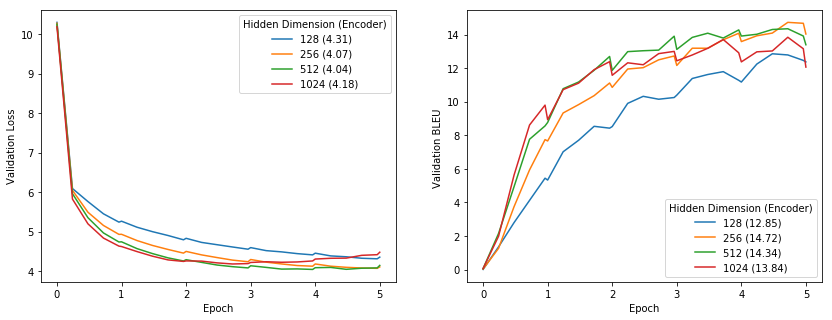

In [25]:
plot_multiple_learning_curves(experiment_results, 'enc_hidden_dim', 'Hidden Dimension (Encoder)')